# Dataset
I am using the "Quark and Gluon Jets" dataset from EnergyFlow [[https://energyflow.network/docs/datasets/#quark-and-gluon-jets]] for the initial part of my project[^1]. I will use this data at two different stages of my project:

**Stage 1 - Hypothesis Testing**

In this phase, I will:
  - Peform **statistical hypothesis tests** ($\chi^{2}$, Likelihood Ratio tests) to verify **quark vs. gluon distributions**.
  - Use features like **multiplicity & jet spread** to check how different quark and gluon jets are.
  - Apply **classification techniques** to separate quark vs. gluon jets.
The goal at this stage is to develop a **baseline statistical understanding** of how quarks vs. gluon jets differ.

**Stage 2 - Bayesian Uncertainty Quantififation**

After completing hypothesis testing, I will:
  - Train a **Neural Network (NN)** to classify quark vs. gluon jets.
  - Modify the NN into a **Bayesian Neural Network (BNN)** to ***quantify*** uncertainty.
  - Test if **Uncertainty Quantification (UQ)** helps improve **classification accuracy** (e.g., are some jets “hard to classify” due to overlapping properties?).


The dataset "Quark and Gluon Jets" focuses only on jet types (*quarks vs. gluon*), not full event-classification. It does not include a wide range of event types (like Higgs decays). So, for UQ, I will switch to "CMS Open Data and the MOD HDF5 Format", again from EnergyFlow [[https://energyflow.network/docs/datasets/#cms-open-data-and-the-mod-hdf5-format]]. 

Why use different dataset later?
- It represents real detector data, where uncertainties arise naturally.
- It allows us to test if ML models trained on simulated jets generalize to real physics data.
- This is crucial for practical applications in experimental physics.

Let's begin by understanding and visualising the dataset.

[^1]: The dataset is a ".npz" file, which is a **compressed NumPy archive**. It stores multiple NumPy arrays inside one file. We have to manually extract arrays before using them (unlike ".csv" - which stores tabular data and can be loaded into Pandas with df.head()).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define file path (using the first file for exploration)
file_path = "/Users/sauravbania/My Projects/Uncertainty-Quantification-CMS/datasets/QG_jets_withbc_0.npz"

# Loading the dataset
data1 = np.load(file_path)

# Checking what arrays are stored in this file
print("Dataset Keys:", data1.files)

# Inspecting the shape of each array
for key in data1.files:
    print(f"{key}: shape {data1[key].shape}")

#Extracting first 5 jets from the X array
X_val = data1["X"]
y_val = data1["y"]

#for i in range(2):
    #print(f"Jet {i}:")
    #print(X_val[i])  # Print the particle features for each jet
    #print(y_val[i])
    #print(f"Label: {'Quark' if y_val[i] == 1 else 'Gluon'}\n")  # Convert label to text

Dataset Keys: ['X', 'y']
X: shape (100000, 134, 4)
y: shape (100000,)


This is telling us that the dataset has two arrays X:(100000,134,4) and y(100000). There are **100000 Quark and Gluon Jets** stored in this file. Each jet consists of a maximum of **134 particles** (multiplicity varies from jet to jet) and has **4 features**. The y array tells us the label for Quarks and Gluons: y == 1 for Quarks and y == 0 for Gluons, as you can clearly see in the output.

As mentioned, the maximum number of multiplicity is 134, so the jets have been padded with zero-particles. I will first like to see how many non-zero particles we have per jet. I just need to check $p_{T}$ i.e., the first feature for each jet for non-zero values. 


100000
134
4
 pT: 0.986502732089,
 rapidity: -1.35386410457, 
 azimuthal angle: 0.26445848313, 
 pdgid: 22.0
Length of multiplicity list: 100000
First 5 jet multiplicities: [44, 41, 38, 52, 45]
Length of gluon multiplicity list: 50000
Length of quark multiplicity list: 50000


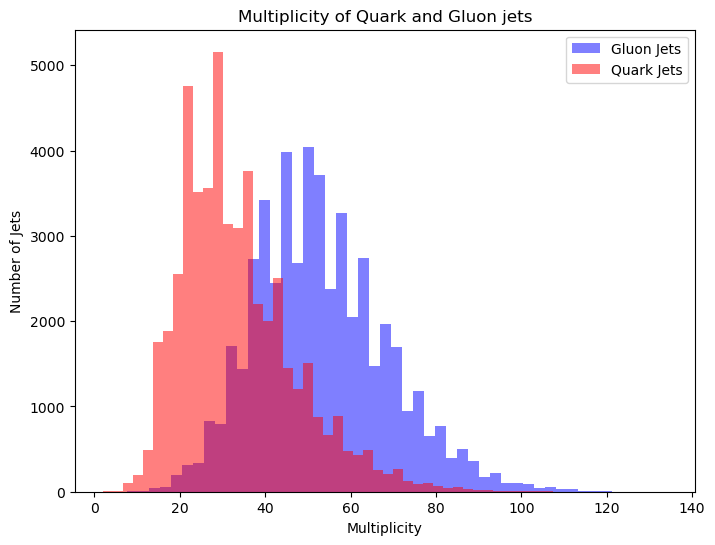

In [2]:
print(len(X_val))
print(len(X_val[0]))
print(len(X_val[0,0]))

print(f" pT: {X_val[0,0,0]},\n rapidity: {X_val[0,0,1]}, \n azimuthal angle: {X_val[0,0,2]}, \n pdgid: {X_val[0,0,3]}") # X_val[0,0,0] = [first jet, first particle in jet, first feature of that particle]

counter = []
for i in range(len(X_val)): # for i in 100000 jets 
    counter.append(np.sum(X_val[i, :, 0] > 0)) # X_val[i, :, 0] = For each jet checking the pT values to be > 0.

print(f"Length of multiplicity list: {len(counter)}")
# print(counter)
print(f"First 5 jet multiplicities: {counter[:5]}")

g_mul = [] # Gluon multiplicity list
q_mul = [] # Quark multiplicity list
for i in range(len(y_val)):
    # print(f"{counter[i]}, {y_val[i]}")
    if y_val[i] == 0.0:
        g_mul.append(counter[i])
        #print(f"Multiplicity of gluon jets:{counter[i]}, {y_val[i]}")
    else:
        q_mul.append(counter[i])

print(f"Length of gluon multiplicity list: {len(g_mul)}")
print(f"Length of quark multiplicity list: {len(q_mul)}")
# Here youprint(q_mul)

plt.figure(figsize=(8, 6))
plt.hist(g_mul, bins=50, alpha=0.5, label="Gluon Jets", color="blue")
plt.hist(q_mul, bins=50, alpha=0.5, label="Quark Jets", color="red")
plt.xlabel('Multiplicity')
plt.ylabel('Number of Jets')
plt.title("Multiplicity of Quark and Gluon jets")
plt.legend()
plt.show()

# plt.figure(figsize=(10, 6))
# plt.hist(X_val[0,0,0], bins=50, alpha=0.5, label="Transverse Momentum", color="blue")
# plt.xlabel('Transverse monentum')
# plt.ylabel('y')
# plt.legend()
# plt.show()


We can see from the plot that the multiplicity of gluon jets is higher than the quark jets, as expected, as quark jets should have fewer particles than gluon jets. The taller bars mean more jets fall in that multiplicity range.

Now, let's understand more about the features and how we can visualize them. 

**Transverse Monentum**

At CMS (LHC), high-energy collisions happen along the beamline. So, the transverse momentum ***$p_{T}$*** tells us how much momentum is carried perpendicular to the beamline. 
From the histogram above, we can see that the Quark jets have fewer particles per jet vs. the Gluon jets. Physics tells us that quark jets tend to have higher $p_{T}$ in fewer particles, and gluon jets tend to distribute $p_{T}$ more broadly across many particles. 

For visualization, we can plot:
- **Jet $p_{T}$ distribution:** To Compare Quark vs. Gluon jets.
- **Mean $p_{T}$ per jet:** To verify if Quarks have higher-energy leading particles. 

**Rapidty $\eta$**

Rapidity describes how **forward or backward** a particle is relative to the beamline.

Defined as:

$\eta = -ln \tan\frac{\theta}{2}$, where $\theta$ is the angle from the beamline.

It is important because it is **Lorentz invariant** - *remains the same under boosts along the beamline*. 

Similarly, we can plot:
- **Rapidity $\eta$ distribution:** To compare quark vs. gluon jets.
- **2D histogram of $(\eta, p_T)$:** To check how transverse momentum varies with rapidity.


**Azimuthal Angle $\phi$**

It represents the angle of the particle in transverse place. It tells us about the spread of the jet. 

So, we can plot:
- **Jet $\phi$ distribution:** To check if quark/gluon jets have uniform spread.
- **$(\eta, \phi)$ scatter plot:** To visualize jet spread in the detector.

| Feature | Plot Type | Goal |
| ----------- | ----------- | ----------- |
| Jet $p_{T}$ distribution | Histogram | Compare quark vs. gluon jets' energy |
| Mean $p_{T}$ per jet | Bar Plot / Box Plot | Check if quarks have higher-energy leading particles |
| Rapidity $\eta$ distribution | Histogram | Compare quark vs. gluon jets' forward/backward spread |
| 2D histogram of $(\eta, p_{T})$ | 2D Heatmap | Show how transverse momentum varies with rapidity |
| Jet $\phi$ distribution | Histogram | Check if quark/gluon jets have uniform angular spread |
| $(\eta, \phi)$ scatter plot | Scatter plot | Visualize jet structure in detector space |


[4.34396513e+00 2.60121413e+00 2.43598450e-02 ... 8.70818191e+01
 1.00271019e+02 1.14074300e+02]


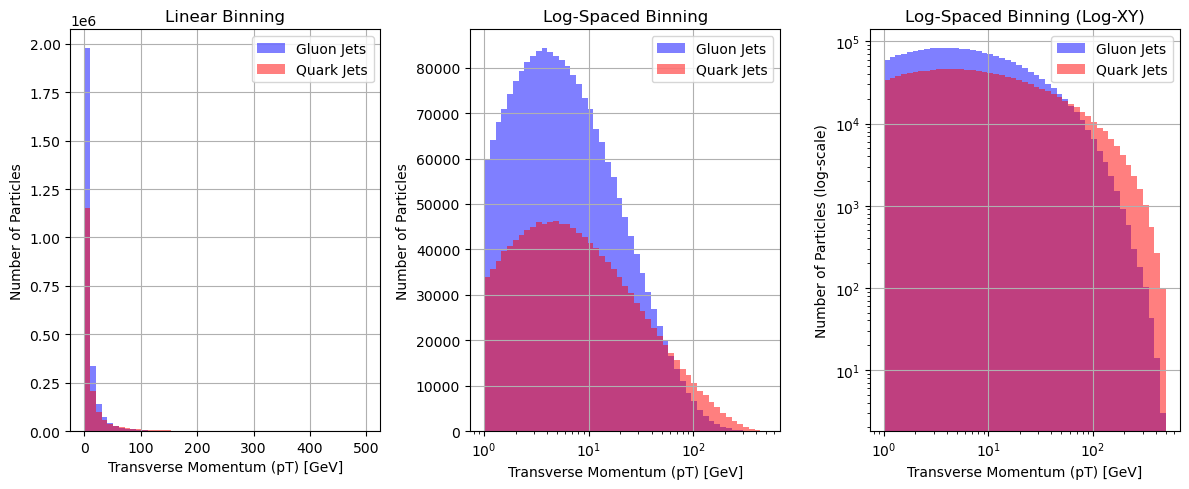

In [3]:
# Transverse Momentum Plots

pT_val = X_val[:,:,0] # Storing all pT values

# The zero-padded values are still there and if we separate now then start plotting then the -
# - zeroes in the dataset will artificially pull the - 
# - distribution toward 0, which is not physically meaningful -
# - since those values are just placeholders for missing particles.

# Separating pT values for wuarks and gluons based on label y
pT_quark = []
pT_gluon = []
for i in range(len(y_val)):
    if y_val[i] == 1:
        pT_quark.append(X_val[i, X_val[i,:,0] > 0, 0]) # X_val[i, X_val[i,:,0] > 0, 0] = X_val[ith jet, pT>0 of all in ith jet, first term]
    if y_val[i] == 0:
        pT_gluon.append(X_val[i, X_val[i,:,0] > 0, 0])

# print(f" Transverse Momentum of all particles: {pT_val}")
# print(f"First 5 quark jet pT values: {pT_quark[:5]}")
# print(f"First 5 gluon jet pT values: {pT_gluon[:5]}")

# pT_quark is now a list of NumPy arrays. We have to flaten it to plot.
pT_quark = np.concatenate(pT_quark)  # Flatten list of arrays into one array
pT_gluon = np.concatenate(pT_gluon) 
print(pT_quark[1:])

bins_log = np.logspace(np.log10(1), np.log10(500), 50)  # Log-spaced bins 
bins_linear = np.linspace(0, 500, 50)

fig, ax = plt.subplots(1, 3, figsize=(12,5)) # 1 row and 3 column

# Plot 1: Regular binning
ax[0].hist(pT_gluon, bins=bins_linear, alpha=0.5, label="Gluon Jets", color="blue")
ax[0].hist(pT_quark, bins=bins_linear, alpha=0.5, label="Quark Jets", color="red")
ax[0].set_xlabel("Transverse Momentum (pT) [GeV]")
ax[0].set_ylabel("Number of Particles")
ax[0].set_title("Linear Binning")
ax[0].legend()
ax[0].grid(True)

# Plot 2: Log-spaced bins
ax[1].hist(pT_gluon, bins=bins_log, alpha=0.5, label="Gluon Jets", color="blue")
ax[1].hist(pT_quark, bins=bins_log, alpha=0.5, label="Quark Jets", color="red")
ax[1].set_xscale("log")  # Log scale on X-axis
ax[1].set_xlabel("Transverse Momentum (pT) [GeV]")
ax[1].set_ylabel("Number of Particles")
ax[1].set_title("Log-Spaced Binning")
ax[1].legend()
ax[1].grid(True)

# Plot 3: Log-XY Scale
ax[2].hist(pT_gluon, bins=bins_log, alpha=0.5, label="Gluon Jets", color="blue")
ax[2].hist(pT_quark, bins=bins_log, alpha=0.5, label="Quark Jets", color="red")
ax[2].set_xscale("log")  # Log scale on X-axis
ax[2].set_yscale("log")  # Log scale on Y-axis
ax[2].set_xlabel("Transverse Momentum (pT) [GeV]")
ax[2].set_ylabel("Number of Particles (log-scale)")
ax[2].set_title("Log-Spaced Binning (Log-XY)")
ax[2].legend()
ax[2].grid(True)


plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


We analyzed the transverse momentum $(p_T)$ distributions of quark and gluon jets using three different binning and scaling approaches. Here’s what I observed:

### **Linear Binning (Left Plot)**

- Uses regular (linear) bins, meaning each bin has equal width.
- The distribution is **highly skewed** toward low $p_T$ values.

#### ***Issues:***
- Difficult to see details at higher $p_T$ since everything is compressed near 0.
- The dominance of low $p_T$ values makes it hard to compare quark vs. gluon jets effectively.

### **Log-Spaced Binning (Middle Plot)**

- Uses log-spaced bins, meaning bin widths increase exponentially as $p_T$ increases.
- The shape is now more balanced, highlighting the high-energy tails.
- Gluon jets (blue) have more low-energy particles, while quark jets (red) have higher-energy leading particles *(expected from QCD)*.

#### ***Remaining Issue:***
- The **Y-axis is still linear**, which makes the low-count regions difficult to see.

### **Log-XY Scale (Right Plot)**

- Uses log-spaced bins + log-scale on both axes.
- Reveals the full shape of the distributions, including **small-count regions**.
- Highlights how gluon jets have a much larger number of **low-energy** particles.


 Mean pT per jet (Quark Jet) - first 2 elements: [0.189254458268, 4.34396513092]
 Mean pT per jet (Gluon Jet) - first 2 elements: [0.986502732089, 1.05703896293]


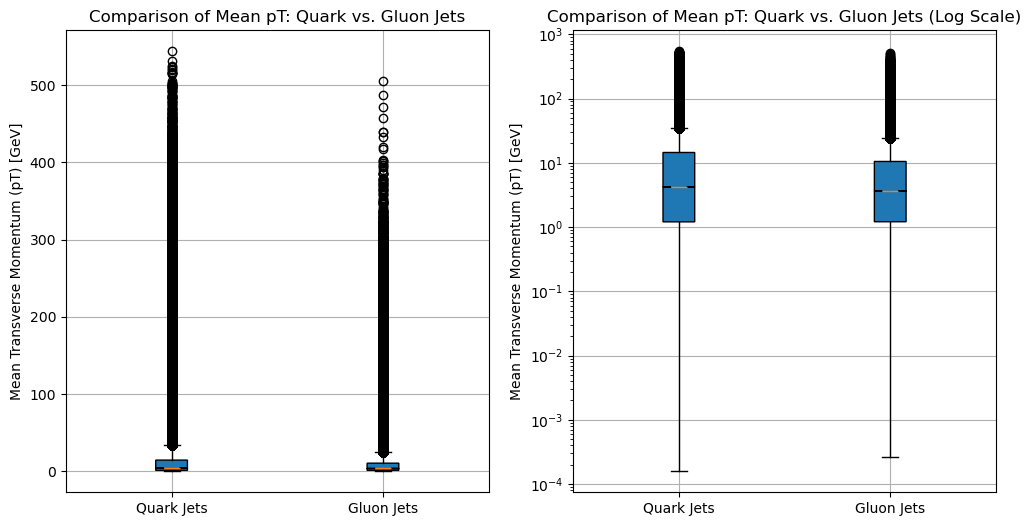

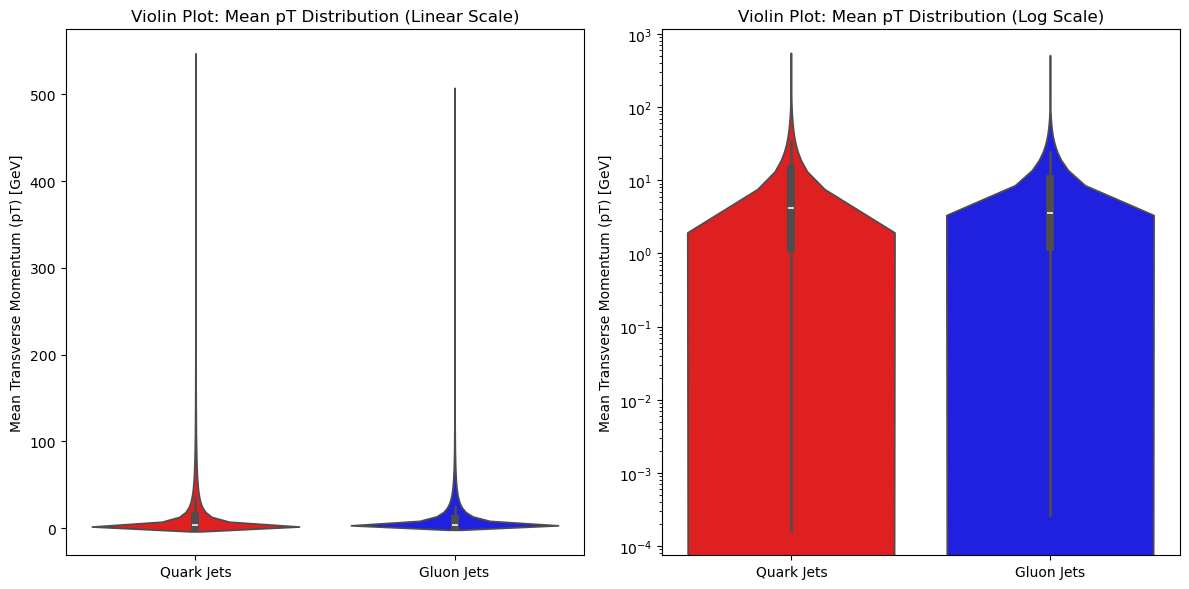

In [4]:
# import sys
# !{sys.executable} -m pip install seaborn
import seaborn as sns

mean_pT_quark = [np.mean(jet) for jet in pT_quark]
mean_pT_gluon = [np.mean(jet) for jet in pT_gluon]


print(f" Mean pT per jet (Quark Jet) - first 2 elements: {mean_pT_quark[:2]}")
print(f" Mean pT per jet (Gluon Jet) - first 2 elements: {mean_pT_gluon[:2]}")


# Remove zero-padded pT values (keep only pT > 0)
filtered_quark_pT = [pT for pT in mean_pT_quark if pT > 0]
filtered_gluon_pT = [pT for pT in mean_pT_gluon if pT > 0]


fig, ax = plt.subplots(1, 2, figsize=(12,6))

# Plot 1: Linear Scale
ax[0].boxplot([filtered_quark_pT, filtered_gluon_pT], notch=True, patch_artist=True)
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(["Quark Jets", "Gluon Jets"])
ax[0].set_ylabel("Mean Transverse Momentum (pT) [GeV]")
ax[0].set_title("Comparison of Mean pT: Quark vs. Gluon Jets")
ax[0].grid(True)

# Plot 2: Log Scale
ax[1].boxplot([filtered_quark_pT, filtered_gluon_pT], notch=True, patch_artist=True)
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels((["Quark Jets", "Gluon Jets"]))
ax[1].set_yscale("log")
ax[1].set_ylabel("Mean Transverse Momentum (pT) [GeV]")
ax[1].set_title("Comparison of Mean pT: Quark vs. Gluon Jets (Log Scale)")
ax[1].grid(True)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Linear scale violin plot (left)
sns.violinplot(data=[mean_pT_quark, mean_pT_gluon], palette=["red", "blue"], ax=ax[0])
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["Quark Jets", "Gluon Jets"])
ax[0].set_ylabel("Mean Transverse Momentum (pT) [GeV]")
ax[0].set_title("Violin Plot: Mean pT Distribution (Linear Scale)")

# Log scale violin plot (right)
sns.violinplot(data=[mean_pT_quark, mean_pT_gluon], palette=["red", "blue"], ax=ax[1])
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["Quark Jets", "Gluon Jets"])
ax[1].set_yscale("log")  # Apply log scale to y-axis
ax[1].set_ylabel("Mean Transverse Momentum (pT) [GeV]")
ax[1].set_title("Violin Plot: Mean pT Distribution (Log Scale)")

# Show the plots
plt.tight_layout()
plt.show()


## **Comparison of Mean \( p_T \) for Quark and Gluon Jets**

To understand the **distribution of transverse momentum $( p_T )$** across quark and gluon jets, we plotted both **box plots** and **violin plots**, each with **linear** and **logarithmic scales**. This allows us to compare the jet energy distributions effectively.

### **Box Plots (Top Row)**

- **Left (Linear Scale):** This box plot shows the raw mean $p_T$ distribution for quark and gluon jets.
- **Right (Log Scale):** Since the linear plot was dominated by extreme outliers, we applied a **log scale** to the y-axis. This makes the data **more readable**, revealing that most jets have lower $p_T$, while a few jets have significantly higher $p_T$.

**Observations:**
- Both distributions are **highly skewed**, with long tails extending toward **higher $p_T$ values**.
- The **median** $p_T$ is comparable for quark and gluon jets, but **gluon jets have a broader distribution** with more low-$p_T$ particles.
- Log scaling helps to **see structure** that was compressed in the linear-scale plot.

### **Violin Plots (Bottom Row)**

- **Left (Linear Scale):** This violin plot provides a **smoothened KDE representation** of the mean $p_T$ distribution, but is still dominated by extreme values.
- **Right (Log Scale):** Using a **log scale**, we better visualize the **core distribution** of $p_T$, showing that quark jets tend to have slightly higher median $p_T$ values, while gluon jets have a **wider spread**.

**Why We Did This Analysis:**
- Jets from quarks and gluons have different **energy distributions**, affecting their experimental identification.
- Gluon jets are expected to have **higher multiplicities** and a broader $p_T$ distribution due to **softer radiation**.
- The log-scale **brings out structure** that was compressed in the linear plots.

### **Key Takeaways:**
- **Box plots** give a **compact summary** of $p_T$ spread & outliers.
- **Violin plots** help **visualize probability density** over the $p_T$ range.
- **Log-scaling** is **crucial** in jet physics due to the extreme range of $p_T$.
- Gluon jets show **broader $p_T$ spread**, while quark jets are **more localized**.

---
These visualizations help us prepare for **further feature engineering and hypothesis testing** in our **uncertainty quantification project** for CMS data.